In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [2]:
# create a dataframe to store the information
df = pd.DataFrame(columns=['text', 'sentiment'])

handle = open('../Data/classify_sen_labeled.json')

for line in handle:
    item = json.loads(line)
    if item['isRelevant'] == 1:
        temp = pd.DataFrame([[item['text'], item['sentiment']]], columns=['text', 'sentiment'])
    df = df.append(temp, ignore_index=True)
handle.close()
df['sentiment'] = df['sentiment'].astype(int)
print(df.head())

                                                text  sentiment
0  destin charger charg normal car 7kw super netw...          1
1             super charger work hard holiday season          2
2                                         gave would          2
3  agre would need major catalyst flip script act...          2
4                    downsiz key emoji_clapping_hand          2


In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def calcScores(y, pred):
    averageType = 'macro'
    accuracy = accuracy_score(y, pred)
    print("Accuracy: %0.4f" % (accuracy))
    recall = recall_score(y, pred, average=averageType)
    print("Recall: %0.4f" % recall)
    precision = precision_score(y, pred, average=averageType)
    print("Precision: %0.4f" % precision)
    f1 = f1_score(y, pred, average=averageType)
    print("F-Score: %0.4f" % f1)
    return accuracy, recall, precision, f1

##split data
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.25, random_state=1)

In [4]:
##Naive Bayes
text_clf_pipe_nb = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('mnb', MultinomialNB(fit_prior=False)),])

text_clf_nb = text_clf_pipe_nb.fit(x_train, y_train)
train_pred_nb = text_clf_nb.predict(x_train)
test_pred_nb = text_clf_nb.predict(x_test)

print("-----Naive Bayes-----")
print("Train")
values_train_nb = calcScores(y_train, train_pred_nb)
print("\nTest")
values_test_nb = calcScores(y_test, test_pred_nb)

##SVM
from sklearn.linear_model import SGDClassifier
text_clf_pipe_svm = Pipeline([('vect', CountVectorizer()),
                              ('tfidf', TfidfTransformer()),
                              ('clf-svm', SGDClassifier(loss='log', 
                                                        penalty='l2', alpha=1e-3, 
                                                        max_iter=5, tol=None, 
                                                        random_state=42))])
text_clf_svm = text_clf_pipe_svm.fit(x_train, y_train)
train_pred_svm = text_clf_svm.predict(x_train)
test_pred_svm = text_clf_svm.predict(x_test)

print("\n-----SVM-----")
print("Train")
values_train_svm = calcScores(y_train, train_pred_svm)
print("\nTest")
values_test_svm = calcScores(y_test, test_pred_svm)
scores = np.column_stack((values_train_nb, values_train_svm, values_test_nb, values_test_svm))

-----Naive Bayes-----
Train
Accuracy: 0.9547
Recall: 0.9523
Precision: 0.9470
F-Score: 0.9495

Test
Accuracy: 0.8593
Recall: 0.8551
Precision: 0.8408
F-Score: 0.8472

-----SVM-----
Train
Accuracy: 0.7935
Recall: 0.6723
Precision: 0.8957
F-Score: 0.7046

Test
Accuracy: 0.6625
Recall: 0.5327
Precision: 0.8355
F-Score: 0.5332


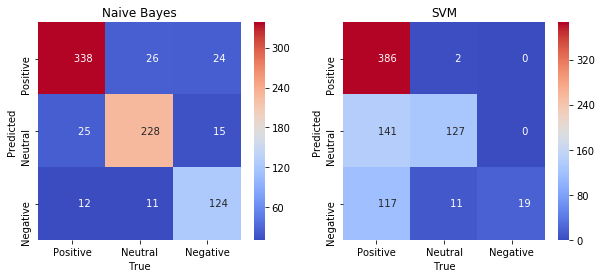

In [5]:
%matplotlib inline
##plot confusion matrices
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def normalizeCM(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm

def createCmDf(cm):
    df_cm = pd.DataFrame(cm, index = ["Positive", "Neutral", "Negative"], columns = ["Positive", "Neutral", "Negative"])
    return df_cm

cm_nb = confusion_matrix(y_test,test_pred_nb, labels = [2, 1, 0])

cm_svm = confusion_matrix(y_test,test_pred_svm, labels = [2, 1, 0])

df_nb = createCmDf(cm_nb)
df_svm = createCmDf(cm_svm)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 4))
fmt = '10d'
im = sn.heatmap(df_nb, ax=ax1, annot=True, cmap='coolwarm', fmt=fmt)
ax1.set_title("Naive Bayes")
ax1.set_xlabel("True")
ax1.set_ylabel("Predicted")
sn.heatmap(df_svm, ax=ax2, annot=True, cmap='coolwarm', fmt=fmt)
ax2.set_title("SVM")
ax2.set_xlabel("True")
ax2.set_ylabel("Predicted")
mappable = im.get_children()[0]
plt.show();